<h1>Comparing vocoid heatmaps for the same speaker</h1>
I'd like to find out whether there is a noticeable difference in the vocoid heatmap that is produced when the same speaker tells two different stories. I can imagine that a different prevalence of vocabulary in different stories might end up creating different vocoid heatmaps, at times that are on the order of minutes. I'll be using two recorded stories from storyteller D01-ST01 (a woman).

In [1]:
import pandas as pd
import numpy as np
import csv

# import matplotlib, start looking at data?
%matplotlib inline
import matplotlib.pyplot as plt

# INFO HERE: https://python-graph-gallery.com/85-density-plot-with-matplotlib/
from scipy.stats import kde

from scipy.spatial import ConvexHull

<h2> Getting the data</h2>
Read in the formant data from CSV files into two NumPy arrays.

In [2]:
story1_formants = pd.read_csv("test1_voiced_formants.txt", sep='\t')
story2_formants = pd.read_csv("test2n_voiced_formants.txt", sep='\t')

In [3]:
story1_formants

,time(s),nformants,F1(Hz),F2(Hz),F3(Hz),F4(Hz),F5(Hz)
0,0.027104,5,469.680,2379.792,3076.838,4097.139,4387.254
1,0.032104,5,458.472,2390.710,3085.790,4091.393,4376.067
2,0.037104,5,450.080,2390.766,3103.524,4092.296,4379.630
3,0.042104,5,443.246,2397.508,3116.202,4114.208,4412.619
4,0.047104,5,439.022,2387.417,3088.642,4132.955,4332.080
...,...,...,...,...,...,...,...
14227,71.162104,4,618.984,1520.413,2985.373,3823.775,--undefined--
14228,71.167104,4,576.803,1496.046,2945.881,3816.134,--undefined--
14229,71.172104,4,539.793,1469.645,2910.814,3805.244,--undefined--
14230,71.177104,4,513.991,1486.523,2891.098,3800.058,--undefined--


In [4]:
story2_formants

,time(s),nformants,F1(Hz),F2(Hz),F3(Hz),F4(Hz),F5(Hz)
0,0.027417,5,391.341,1578.779,2653.640,3856.339,4848.753
1,0.032417,5,398.637,1592.175,2830.527,3823.956,4874.265
2,0.037417,5,405.665,1501.404,3102.757,3816.236,5031.368
3,0.042417,5,428.820,1466.258,2935.892,3583.572,4976.970
4,0.047417,5,430.647,1485.601,2701.784,3576.297,5008.974
...,...,...,...,...,...,...,...
14308,71.567417,4,415.138,2390.558,3338.062,3747.890,--undefined--
14309,71.572417,4,412.506,2383.119,3367.337,3776.224,--undefined--
14310,71.577417,4,411.552,2383.734,3356.668,3827.694,--undefined--
14311,71.582417,4,416.175,2427.454,3326.714,3883.364,--undefined--


<h2>Normalizing the data</h2>
For comparison, we need to normalize data:

$$F_j^* (n) = \frac{F_j(n) - F_j^{median}}{F_j^{median}} \text{ ,  for  } j = \{1, 2\} \text{ , }n = \{1 ... N\}$$

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5724721/

In [5]:
story1_formants["F1n"], story1_formants["F2n"] = (story1_formants["F1(Hz)"] - story1_formants["F1(Hz)"].median()) / story1_formants["F1(Hz)"].median(), (story1_formants["F2(Hz)"] - story1_formants["F2(Hz)"].median()) / story1_formants["F2(Hz)"].median()
story1_formants

,time(s),nformants,F1(Hz),F2(Hz),F3(Hz),F4(Hz),F5(Hz),F1n,F2n
0,0.027104,5,469.680,2379.792,3076.838,4097.139,4387.254,0.049842,0.346941
1,0.032104,5,458.472,2390.710,3085.790,4091.393,4376.067,0.024790,0.353120
2,0.037104,5,450.080,2390.766,3103.524,4092.296,4379.630,0.006032,0.353152
3,0.042104,5,443.246,2397.508,3116.202,4114.208,4412.619,-0.009244,0.356968
4,0.047104,5,439.022,2387.417,3088.642,4132.955,4332.080,-0.018685,0.351257
...,...,...,...,...,...,...,...,...,...
14227,71.162104,4,618.984,1520.413,2985.373,3823.775,--undefined--,0.383571,-0.139460
14228,71.167104,4,576.803,1496.046,2945.881,3816.134,--undefined--,0.289287,-0.153251
14229,71.172104,4,539.793,1469.645,2910.814,3805.244,--undefined--,0.206561,-0.168194
14230,71.177104,4,513.991,1486.523,2891.098,3800.058,--undefined--,0.148887,-0.158641


In [6]:
story2_formants["F1n"], story2_formants["F2n"] = (story2_formants["F1(Hz)"] - story2_formants["F1(Hz)"].median()) / story2_formants["F1(Hz)"].median(), (story2_formants["F2(Hz)"] - story2_formants["F2(Hz)"].median()) / story2_formants["F2(Hz)"].median()
story2_formants

,time(s),nformants,F1(Hz),F2(Hz),F3(Hz),F4(Hz),F5(Hz),F1n,F2n
0,0.027417,5,391.341,1578.779,2653.640,3856.339,4848.753,-0.144005,-0.065918
1,0.032417,5,398.637,1592.175,2830.527,3823.956,4874.265,-0.128047,-0.057993
2,0.037417,5,405.665,1501.404,3102.757,3816.236,5031.368,-0.112674,-0.111697
3,0.042417,5,428.820,1466.258,2935.892,3583.572,4976.970,-0.062026,-0.132491
4,0.047417,5,430.647,1485.601,2701.784,3576.297,5008.974,-0.058030,-0.121047
...,...,...,...,...,...,...,...,...,...
14308,71.567417,4,415.138,2390.558,3338.062,3747.890,--undefined--,-0.091953,0.414369
14309,71.572417,4,412.506,2383.119,3367.337,3776.224,--undefined--,-0.097711,0.409968
14310,71.577417,4,411.552,2383.734,3356.668,3827.694,--undefined--,-0.099797,0.410332
14311,71.582417,4,416.175,2427.454,3326.714,3883.364,--undefined--,-0.089685,0.436198


<h2>Displaying and comparing</h2>
Let's plot the vowel space density for both samples. Is there a difference that is visible on inspection? If inspection shows no difference, is there a better way to calculate how much difference there might be?

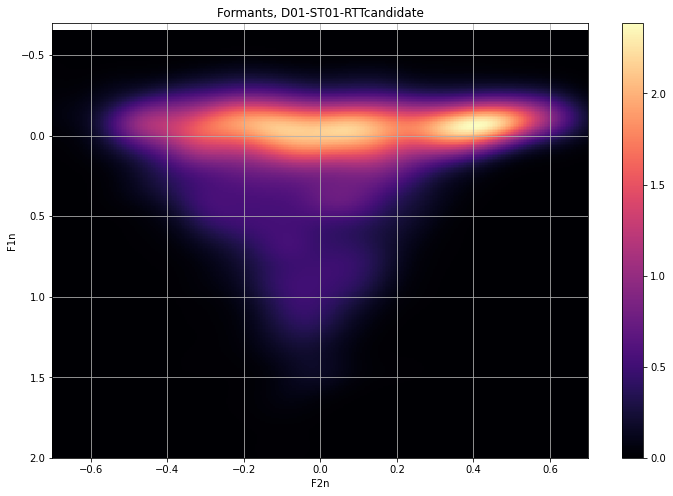

In [8]:
# formants["F2n", "F1n"].plot.kde
fig, ax = plt.subplots()

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=400
k = kde.gaussian_kde([story1_formants["F2n"],story1_formants["F1n"]])
xi, yi = np.mgrid[story1_formants["F2n"].min():story1_formants["F2n"].max():nbins*1j,
                  story1_formants["F1n"].min():story1_formants["F1n"].max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# Make the plot
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.magma)
plt.colorbar()
ax.set_ylim(2.0, -0.7)  # decreasing F1
ax.set_xlim(-0.7, 0.7)
ax.set(xlabel='F2n', ylabel='F1n',
       title='Formants, D01-ST01-RTTcandidate')
ax.grid()
plt.rcParams['figure.figsize'] = [12, 8]

#fig.savefig("D01-ST01-RTTcandidate.png")
plt.show()

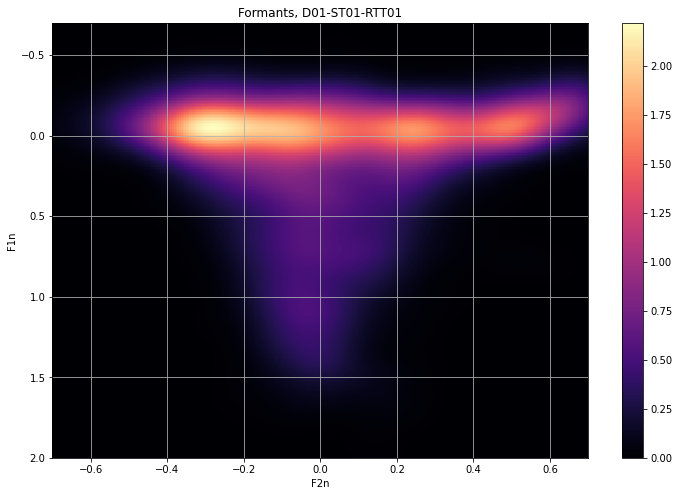

In [9]:
# formants["F2n", "F1n"].plot.kde
fig, ax = plt.subplots()

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=400
k = kde.gaussian_kde([story2_formants["F2n"],story2_formants["F1n"]])
xi, yi = np.mgrid[story2_formants["F2n"].min():story2_formants["F2n"].max():nbins*1j,
                  story2_formants["F1n"].min():story2_formants["F1n"].max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# Make the plot
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.magma)
plt.colorbar()

ax.set_ylim(2.0, -0.7)  # decreasing F1
ax.set_xlim(-0.7, 0.7)
ax.set(xlabel='F2n', ylabel='F1n',
       title='Formants, D01-ST01-RTT01')
ax.grid()
plt.rcParams['figure.figsize'] = [12, 8]

#fig.savefig("D01-ST01-RTT01.png")
plt.show()

This is interesting! The overall area that gets used seems to be about the same based just on a visual comparison, but the peaks are certainly different. It would be good to actually calculate the hull area for these two samples, or find a way to show more clearly that the peaks are at different positions in the formant space, or even plot the two hulls and compare their shape.

<h2>Some options for display</h2>
Now to try to get an isometric mesh plot, to bring out the different locations of the peaks.

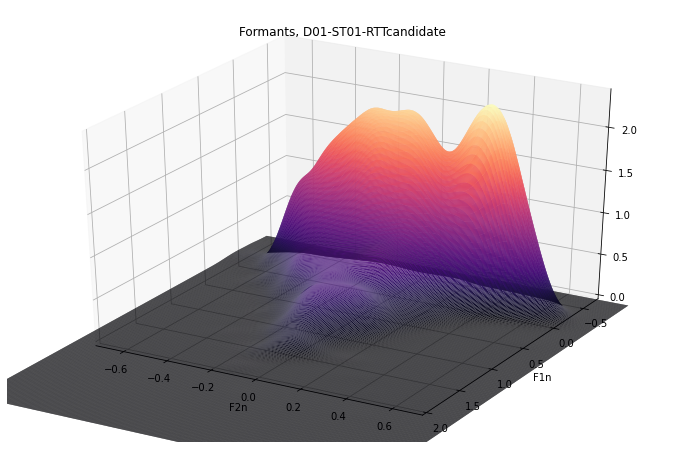

In [10]:
# from https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html#Wireframes-and-Surface-Plots
fig = plt.figure()
ax = plt.axes(projection='3d')

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=400
k = kde.gaussian_kde([story1_formants["F2n"],story1_formants["F1n"]])
xi, yi = np.mgrid[story1_formants["F2n"].min():story1_formants["F2n"].max():nbins*1j,
                  story1_formants["F1n"].min():story1_formants["F1n"].max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

#plt.colorbar()

#ax.set_xlim(2600, 400)  # decreasing F2
ax.set_ylim(2.0, -0.7)  # decreasing F1
ax.set_xlim(-0.7, 0.7)
ax.set(xlabel='F2n', ylabel='F1n',
       title='Formants, D01-ST01-RTTcandidate')
ax.grid()

# Make the plot

ax.plot_surface(xi, yi, zi.reshape(xi.shape), rstride=1, cstride=1,
                cmap=plt.cm.magma, edgecolor='none')

plt.rcParams['figure.figsize'] = [12, 8]

#fig.savefig("D01-ST01-RTTcandidate-3d.png")
plt.show()

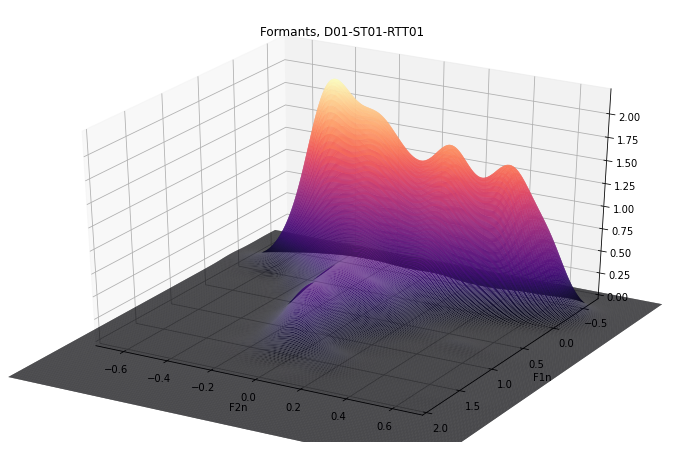

In [11]:
# from https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html#Wireframes-and-Surface-Plots
fig = plt.figure()
ax = plt.axes(projection='3d')

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=400
k = kde.gaussian_kde([story2_formants["F2n"],story2_formants["F1n"]])
xi, yi = np.mgrid[story2_formants["F2n"].min():story2_formants["F2n"].max():nbins*1j,
                  story2_formants["F1n"].min():story2_formants["F1n"].max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

#plt.colorbar()

#ax.set_xlim(2600, 400)  # decreasing F2
ax.set_ylim(2.0, -0.7)  # decreasing F1
ax.set_xlim(-0.7, 0.7)
ax.set(xlabel='F2n', ylabel='F1n',
       title='Formants, D01-ST01-RTT01')
ax.grid()

# Make the plot

ax.plot_surface(xi, yi, zi.reshape(xi.shape), rstride=1, cstride=1,
                cmap=plt.cm.magma, edgecolor='none')

plt.rcParams['figure.figsize'] = [12, 8]

#fig.savefig("D01-ST01-RTT01-3d.png")
plt.show()

<h2>Convex hull</h2>
Lastly, I'd like to get the hull calculation to be at P=0.2 (or any arbitrary value), rather than including all data points. Start by looking at what these nparrays actually are:

In [12]:
#xi
xi.shape
#yi
#zi
#zi.min()
#zi.max()

(400, 400)

The use of <code>mgrid</code> to generate <code>xi</code> and <code>yi</code> is a way to get the effect of a loop over all x and y points in a grid, without actually running a loop. The nparray <code>xi</code> goes through the x values of an <code>nbins * nbins</code> grid, and <code>yi</code> goes through the y values of an <code>nbins * nbins</code> grid. The nparray <code>zi</code> is a one-domensional array which, when you shape it like <code>xi</code> (not <code>yi</code>, because it's linearly flattened by x-row, not by y-column), gives you all the z values (ie, the values of the probability density function generated from the kernel density estimation)at those points.

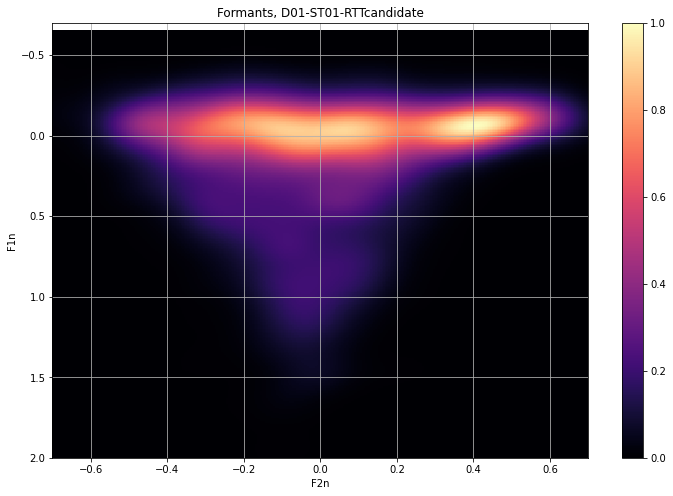

In [13]:
# formants["F2n", "F1n"].plot.kde
fig, ax = plt.subplots()

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=400
k = kde.gaussian_kde([story1_formants["F2n"],story1_formants["F1n"]])
xi, yi = np.mgrid[story1_formants["F2n"].min():story1_formants["F2n"].max():nbins*1j,
                  story1_formants["F1n"].min():story1_formants["F1n"].max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
znorm = zi / zi.max()
 
# Make the plot
plt.pcolormesh(xi, yi, znorm.reshape(xi.shape), cmap=plt.cm.magma)
plt.colorbar()
ax.set_ylim(2.0, -0.7)  # decreasing F1
ax.set_xlim(-0.7, 0.7)
ax.set(xlabel='F2n', ylabel='F1n',
       title='Formants, D01-ST01-RTTcandidate')
ax.grid()

plt.rcParams['figure.figsize'] = [12, 8]


#fig.savefig("D01-ST01-RTTcandidate.png")
plt.show()

In [14]:
vsd = pd.DataFrame(list(zip(xi.flatten(), yi.flatten(), znorm)),
                  columns=['x', 'y', 'value'])
vsd 

,x,y,value
0,-0.800007,-0.654034,0.000899
1,-0.800007,-0.643788,0.000984
2,-0.800007,-0.633543,0.001073
3,-0.800007,-0.623298,0.001166
4,-0.800007,-0.613053,0.001266
...,...,...,...
159995,0.889830,3.392812,0.000091
159996,0.889830,3.403058,0.000089
159997,0.889830,3.413303,0.000086
159998,0.889830,3.423548,0.000081


In [15]:
filter = vsd['value']>=0.20
vsd_filtered = vsd[filter]

In [16]:
hull = ConvexHull(vsd_filtered[["x","y"]])

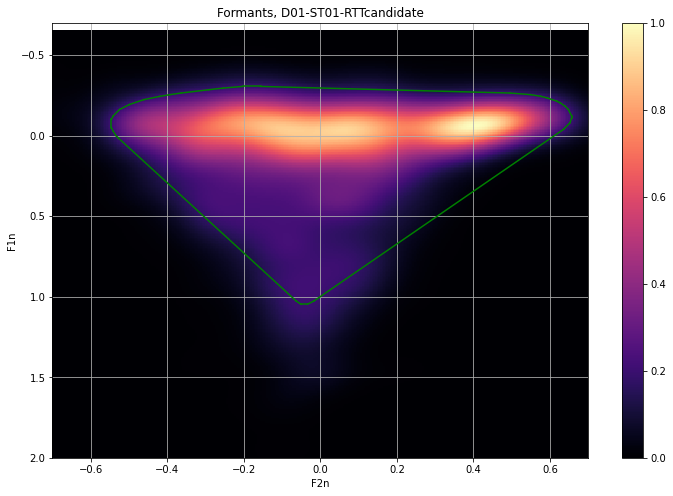

In [17]:
fig, ax = plt.subplots()
plt.pcolormesh(xi, yi, znorm.reshape(xi.shape), cmap=plt.cm.magma)
plt.colorbar()
ax.set_ylim(2.0, -0.7)  # decreasing F1
ax.set_xlim(-0.7, 0.7)
ax.set(xlabel='F2n', ylabel='F1n',
       title='Formants, D01-ST01-RTTcandidate')
ax.grid()
plt.rcParams['figure.figsize'] = [12, 8]

for simplex in hull.simplices:
    plt.plot(vsd_filtered["x"].iloc[simplex], vsd_filtered["y"].iloc[simplex], 'g-')

plt.show()

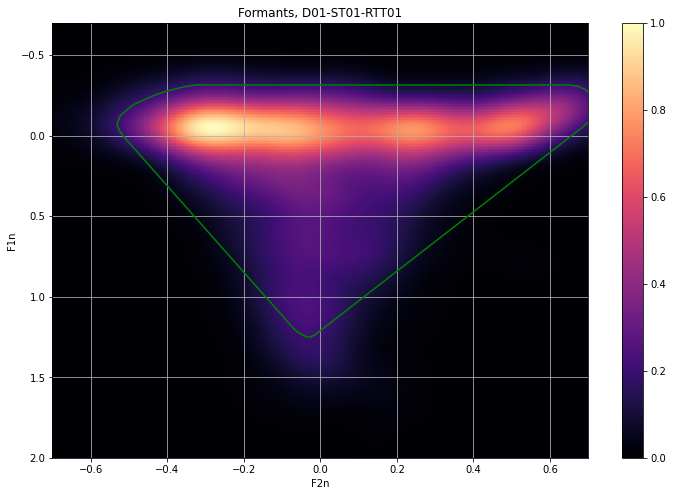

In [18]:
# formants["F2n", "F1n"].plot.kde
fig, ax = plt.subplots()

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=400
k = kde.gaussian_kde([story2_formants["F2n"],story2_formants["F1n"]])
xi, yi = np.mgrid[story2_formants["F2n"].min():story2_formants["F2n"].max():nbins*1j,
                  story2_formants["F1n"].min():story2_formants["F1n"].max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
znorm = zi / zi.max()

vsd = pd.DataFrame(list(zip(xi.flatten(), yi.flatten(), znorm)),
                  columns=['x', 'y', 'value'])
filter = vsd['value']>=0.20
vsd_filtered = vsd[filter]
hull = ConvexHull(vsd_filtered[["x","y"]])
 
# Make the plot
plt.pcolormesh(xi, yi, znorm.reshape(xi.shape), cmap=plt.cm.magma)
plt.colorbar()
ax.set_ylim(2.0, -0.7)  # decreasing F1
ax.set_xlim(-0.7, 0.7)
ax.set(xlabel='F2n', ylabel='F1n',
       title='Formants, D01-ST01-RTT01')
ax.grid()

plt.rcParams['figure.figsize'] = [12, 8]

for simplex in hull.simplices:
    plt.plot(vsd_filtered["x"].iloc[simplex], vsd_filtered["y"].iloc[simplex], 'g-')

#fig.savefig("D01-ST01-RTT01.png")
plt.show()